In [1]:

import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

sns.set(style="darkgrid")

In [3]:
# Try to parse the dates right at the beginning
# It works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('C:/Users/Asus/ads_covid-19/data/processed/COVID_small_flat_table.csv',sep=';')
df_analyse.sort_values('date',ascending=True).tail()

,date,Italy,United Kingdom,Spain,Germany,"Korea, South"
225,2020-09-03,272912,342708,488513,248840,20842
226,2020-09-04,274644,344686,498989,250283,21010
227,2020-09-05,276338,346513,498989,251058,21177
228,2020-09-06,277634,349500,498989,251728,21296
229,2020-09-07,278784,352451,525549,253626,21432


In [4]:
df_analyse.Germany[35]

27

In [5]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [6]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

In [7]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)    

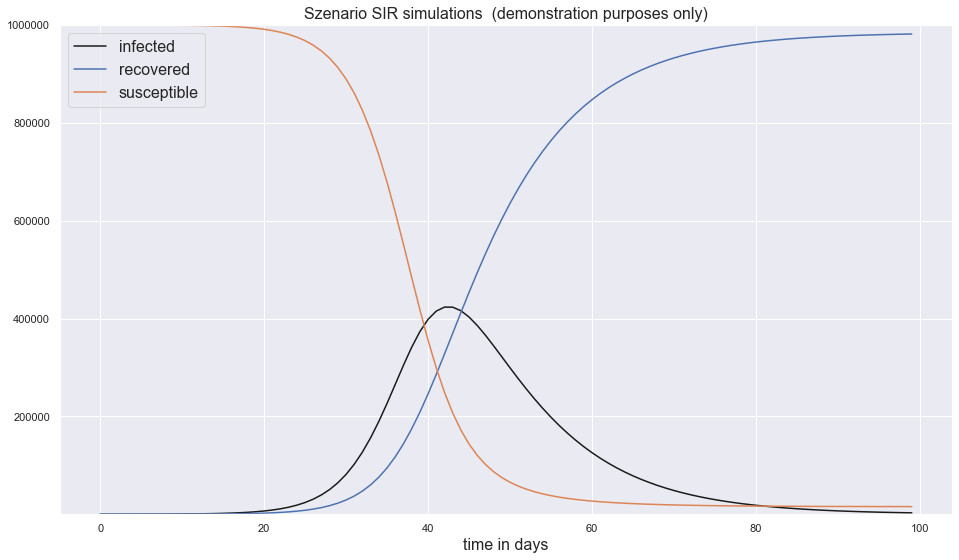

In [8]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [9]:
ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))

In [10]:
# ensure re-initialization 
N0=253626
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [11]:

def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt 

In [12]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [13]:
# example curve of our differential equation
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([2.70000000e+01, 3.64442922e+01, 4.91909506e+01, 6.63937712e+01,
       8.96088979e+01, 1.20934500e+02, 1.63198411e+02, 2.20209795e+02,
       2.97095878e+02, 4.00751116e+02, 5.40433765e+02, 7.28553537e+02,
       9.81703102e+02, 1.32199354e+03, 1.77875545e+03, 2.39065535e+03,
       3.20823747e+03, 4.29681012e+03, 5.73941920e+03, 7.63933938e+03,
       1.01210188e+04, 1.33277185e+04, 1.74132954e+04, 2.25250378e+04,
       2.87749418e+04, 3.61994335e+04, 4.47132156e+04, 5.40708517e+04,
       6.38558188e+04, 7.35142775e+04, 8.24355091e+04, 9.00582677e+04,
       9.59669882e+04, 9.99460226e+04, 1.01981025e+05, 1.02219083e+05,
       1.00910168e+05, 9.83502769e+04, 9.48377892e+04, 9.06459475e+04,
       8.60091974e+04, 8.11192763e+04, 7.61271339e+04, 7.11477473e+04,
       6.62659348e+04, 6.15420954e+04, 5.70173559e+04, 5.27179343e+04,
       4.86587142e+04, 4.48460990e+04, 4.12802561e+04, 3.79568593e+04,
       3.48684275e+04, 3.20053449e+04, 2.93566324e+04, 2.69105260e+04,
      

In [14]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

F:\Software installations\Anaconda\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
F:\Software installations\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
F:\Software installations\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
F:\Software installations\Anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
F:\Software installations\Anaconda\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00357118 0.0001941 ]  start infect: 27
Optimal parameters: beta = 0.19133134915733743  and gamma =  0.002034476961781571


In [15]:

# get the final fitted curve
fitted=fit_odeint(t, *popt)

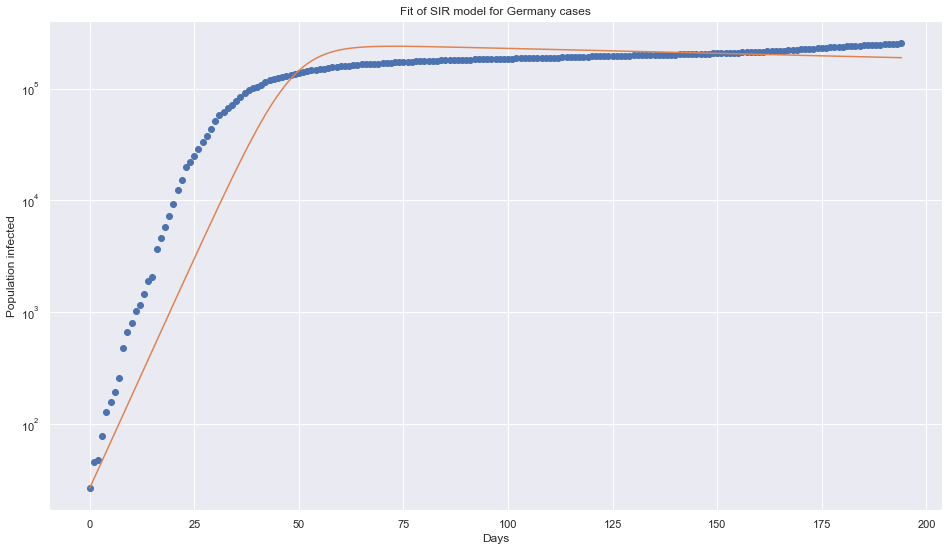

Optimal parameters: beta = 0.19133134915733743  and gamma =  0.002034476961781571
Basic Reproduction Number R0  94.04449042754975
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [16]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in SIR (infection rate)

In [17]:
t_initial=26
t_intro_measures=10
t_hold=150
t_relax=10

beta_max=0.33
beta_min=0.001
gamma=0.001
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))
pd_beta

array([0.33      , 0.33      , 0.33      , 0.33      , 0.33      ,
       0.33      , 0.33      , 0.33      , 0.33      , 0.33      ,
       0.33      , 0.33      , 0.33      , 0.33      , 0.33      ,
       0.33      , 0.33      , 0.33      , 0.33      , 0.33      ,
       0.33      , 0.33      , 0.33      , 0.33      , 0.33      ,
       0.33      , 0.33      , 0.29344444, 0.25688889, 0.22033333,
       0.18377778, 0.14722222, 0.11066667, 0.07411111, 0.03755556,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001  

In [18]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)    

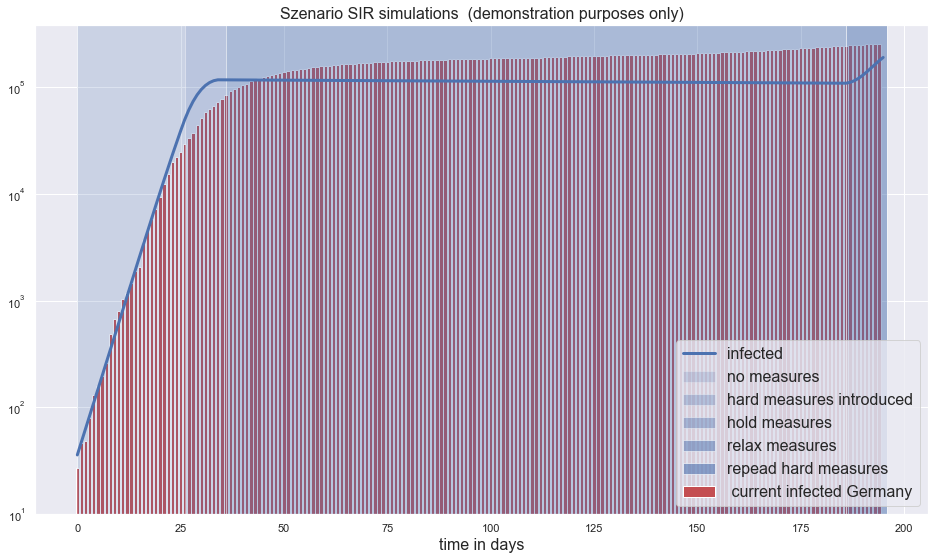

In [19]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*(ydata[len(ydata)-1]))
ax1.set_yscale('log')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});